# Task 2: Transfer Learning with Pretrained Models for Pet Classification

# 1. Introduction and Setup

In this notebook, we'll use transfer learning with pretrained models to classify pet breeds from the Oxford-IIIT Pet Dataset. We'll compare different architectures and fine-tuning strategies to find the best approach.

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report

## 1.2 Set Up Environment and Reproducibility

Setting a random seed ensures that our results are reproducible across different runs.

In [2]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # Set deterministic backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed()

# Check for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# 2. Data Loading and Preprocessing

We'll load the Oxford-IIIT Pet Dataset and apply appropriate transformations for transfer learning with pretrained models.

## 2.1 Define Data Transformations

For transfer learning, we need to use the normalization values that the pretrained models expect, which are typically the ImageNet statistics.

In [3]:
# For transfer learning, we need to use the normalization values that the pretrained models expect
# These values are the mean and std from ImageNet dataset

# Transformations for training (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformations for validation/testing (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## 2.2 Load the Oxford-IIIT Pet Dataset

Let's load the dataset and create appropriate data loaders.

In [4]:
# Load train+validation and test sets
trainval_dataset = datasets.OxfordIIITPet(root="./data", split="trainval", transform=train_transform, download=True)
test_dataset = datasets.OxfordIIITPet(root="./data", split="test", transform=val_transform, download=True)

# Split trainval into train and validation
train_size = int(0.8 * len(trainval_dataset))
val_size = len(trainval_dataset) - train_size
train_dataset, val_dataset = random_split(trainval_dataset, [train_size, val_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Get class information
class_to_idx = trainval_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
num_classes = len(class_to_idx)
print(f"Number of classes: {num_classes}")

Train set size: 2944
Validation set size: 736
Test set size: 3669
Number of classes: 37


## 2.3 Explore the Dataset

Let's visualize some samples from the dataset and analyze the class distribution.

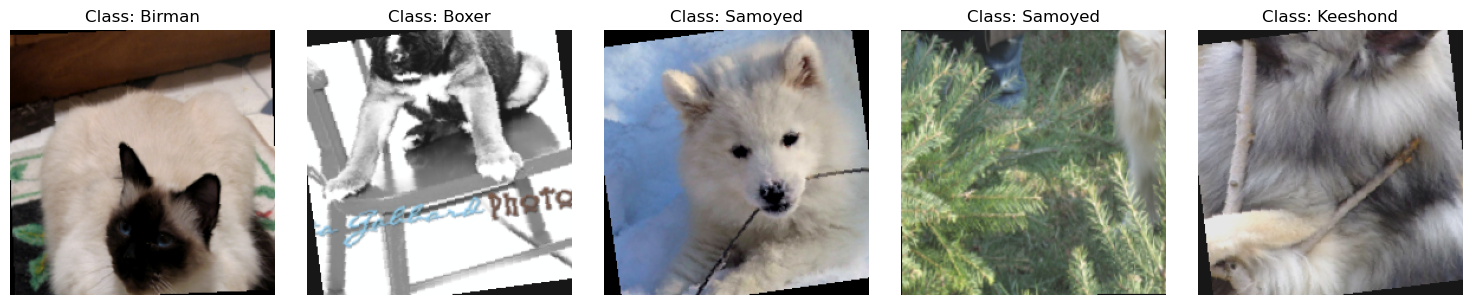

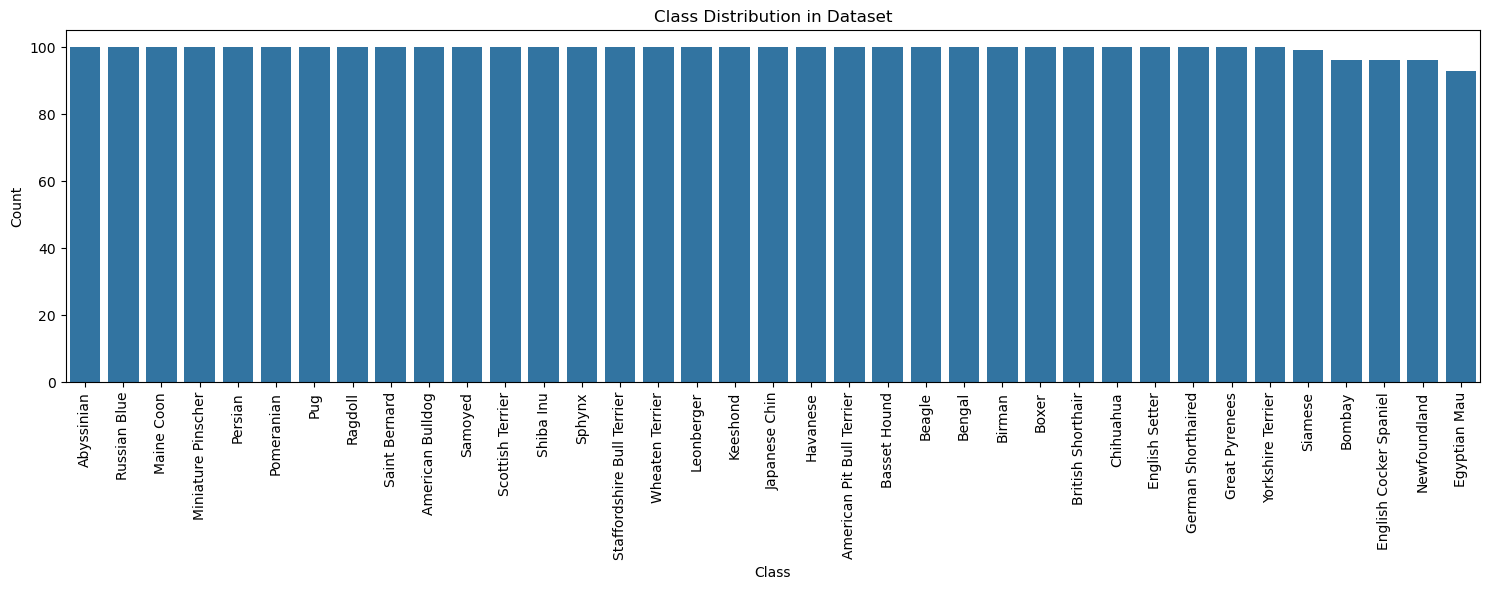

In [5]:
# Display a few training samples
def show_samples(dataloader, num_samples=5):
    # Get a batch of images and labels
    images, labels = next(iter(dataloader))
    
    # Display images
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        img = images[i].permute(1, 2, 0).numpy()
        # Denormalize for visualization
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(f"Class: {idx_to_class[labels[i].item()]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_samples(train_loader)

# Analyze class distribution
def analyze_class_distribution(dataset):
    # Count occurrences of each class
    class_counts = {i: 0 for i in range(num_classes)}
    
    for _, label in dataset:
        class_counts[label] += 1
    
    # Convert to DataFrame for visualization
    class_df = pd.DataFrame({
        'Class': [idx_to_class[i] for i in range(num_classes)],
        'Count': [class_counts[i] for i in range(num_classes)]
    })
    
    # Sort by count for better visualization
    class_df = class_df.sort_values('Count', ascending=False)
    
    # Plot
    plt.figure(figsize=(15, 6))
    sns.barplot(x='Class', y='Count', data=class_df)
    plt.xticks(rotation=90)
    plt.title('Class Distribution in Dataset')
    plt.tight_layout()
    plt.show()
    
    return class_df

class_distribution = analyze_class_distribution(trainval_dataset)

# 3. Task 2 - Step 1: Using a Pretrained Model

In this section, we'll load pretrained models and adapt them for our pet classification task.

## 3.1 Load and Explore Pretrained Models

Let's examine different pretrained models available in PyTorch and adapt them for our task.

In [6]:
# Function to load a pretrained model
def load_pretrained_model(model_name, num_classes=37):
    if model_name == 'resnet18':
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    
    elif model_name == 'resnet50':
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    
    elif model_name == 'vgg16':
        model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, num_classes)
    
    elif model_name == 'densenet121':
        model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
    
    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    
    else:
        raise ValueError(f"Unsupported model: {model_name}")
    
    return model

# Explore the architecture of a pretrained ResNet50
resnet50 = load_pretrained_model('resnet50')
print(resnet50)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/ndethi/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:53<00:00, 1.90MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 3.2 Implement Transfer Learning Strategy

For transfer learning, we'll start by freezing all pretrained layers and only training the new classifier layer.

In [7]:
# We'll start with a simple strategy: freeze all pretrained layers and only train the new classifier

def freeze_parameters(model, model_name):
    if model_name in ['resnet18', 'resnet50']:
        # Freeze all parameters
        for param in model.parameters():
            param.requires_grad = False
        # Unfreeze the final fully connected layer
        for param in model.fc.parameters():
            param.requires_grad = True
    
    elif model_name == 'vgg16':
        # Freeze all parameters
        for param in model.parameters():
            param.requires_grad = False
        # Unfreeze the classifier
        for param in model.classifier[6].parameters():
            param.requires_grad = True
    
    elif model_name == 'densenet121':
        # Freeze all parameters
        for param in model.parameters():
            param.requires_grad = False
        # Unfreeze the classifier
        for param in model.classifier.parameters():
            param.requires_grad = True
    
    elif model_name == 'efficientnet_b0':
        # Freeze all parameters
        for param in model.parameters():
            param.requires_grad = False
        # Unfreeze the classifier
        for param in model.classifier[1].parameters():
            param.requires_grad = True
    
    # Count trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    
    print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%} of total)")
    
    return model

# Let's use ResNet50 as our first model
model_name = 'resnet50'
model = load_pretrained_model(model_name)
model = freeze_parameters(model, model_name)
model = model.to(device)

Trainable parameters: 75,813 (0.32% of total)


## 3.3 Define Training Function for Transfer Learning

Let's define a function to train our adapted pretrained models.

In [8]:
# Define training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, model_name="model"):
    start_time = time.time()
    best_val_acc = 0.0
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        # Iterate over data
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward + optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        # No gradient computation for validation
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Forward
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Statistics
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels)
        
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_running_corrects.double() / len(val_loader.dataset)
        
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc.item())
        
        print(f'Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')
        
        # Update learning rate based on validation loss
        if scheduler:
            scheduler.step(val_epoch_loss)
        
        # Save the best model
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            torch.save(model.state_dict(), f'best_{model_name}.pth')
    
    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_val_acc:.4f}')
    
    # Load the best model
    model.load_state_dict(torch.load(f'best_{model_name}.pth'))
    return model, history, time_elapsed

## 3.4 Train ResNet50 with Transfer Learning

Now let's train our ResNet50 model using transfer learning.

In [10]:
# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)

# Train the model
trained_model, history, training_time = train_model(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    scheduler, 
    num_epochs=2,
    model_name=model_name
)

Epoch 1/2
----------
Train Loss: 0.8586 Acc: 0.7510
Val Loss: 0.7262 Acc: 0.7894
Epoch 2/2
----------
Train Loss: 0.7316 Acc: 0.7843
Val Loss: 0.6930 Acc: 0.7867
Training complete in 20m 4s
Best val Acc: 0.7894


### Visualize Training Results

Let's plot the training and validation loss/accuracy curves.

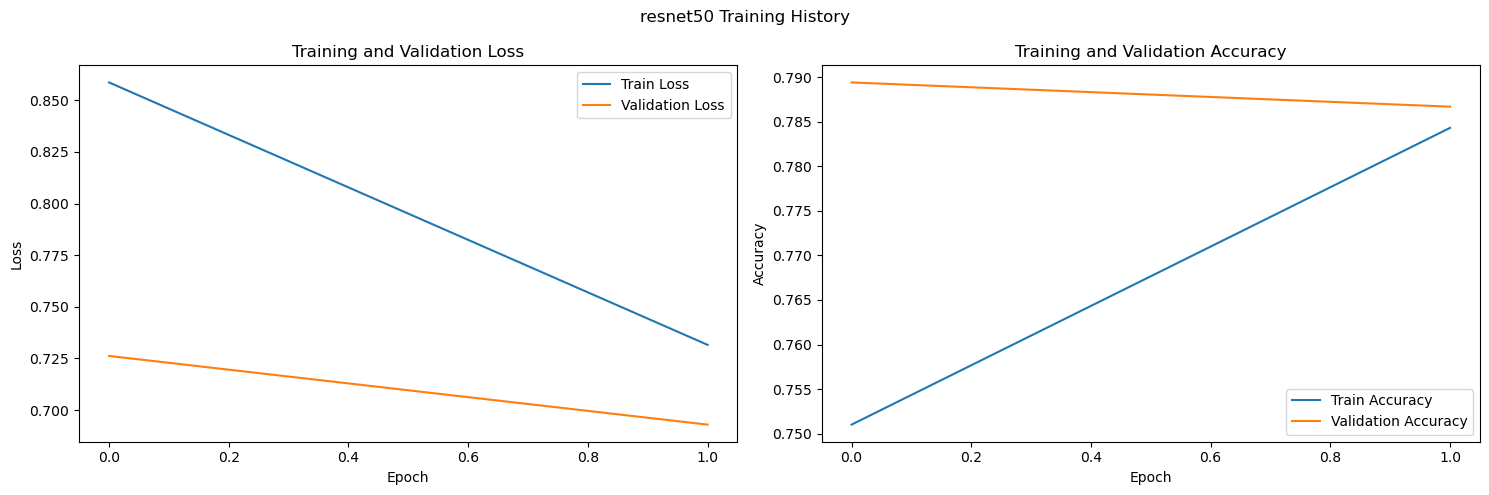

In [11]:
# Plot training history
def plot_training_history(history, title="Training History"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    
    # Plot accuracy
    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_training_history(history, title=f"{model_name} Training History")

## 3.5 Evaluate ResNet50 on Test Set

Let's evaluate the performance of our pretrained ResNet50 model on the test set.

In [17]:
def evaluate_model(model, test_loader, num_classes=37):
    model.eval()
    running_corrects = 0
    all_preds = []
    all_labels = []
    
    # For per-class accuracy
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Collect predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Count correct predictions per class
            c = (preds == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            
            # Count total correct predictions
            running_corrects += torch.sum(preds == labels)
    
    # Calculate overall accuracy
    acc = running_corrects.double() / len(test_loader.dataset)
    print(f"Test Accuracy: {acc:.4f}")
    
    # Calculate per-class accuracy
    class_accuracies = [(i, class_correct[i] / class_total[i]) for i in range(num_classes) if class_total[i] > 0]
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=[idx_to_class[i] for i in range(num_classes)])
    print(report)
    
    return acc, class_accuracies, cm, report

# If we've already evaluated a model and want to display the results:
if 'trained_model' in locals():
    print("Evaluating the ResNet50 model on the test dataset...")
    final_acc, final_class_accuracies, final_cm, final_report = evaluate_model(trained_model, test_loader)
    
    print("Submit final accuracy to the form: RAI-8002 Assessment 1 - Task 2 - Accuracy")
    
    # Prepare leaderboard submission
    print("\n" + "="*50)
    print("LEADERBOARD SUBMISSION")
    print("="*50)
    print(f"Final accuracy for submission: {final_acc:.6f}")
    print("="*50)
    print("Copy this number and submit it to the provided form.")

Evaluating the ResNet50 model on the test dataset...
Test Accuracy: 0.8678
                            precision    recall  f1-score   support

                Abyssinian       0.93      0.67      0.78        98
          American Bulldog       0.69      0.83      0.75       100
 American Pit Bull Terrier       0.86      0.43      0.57       100
              Basset Hound       0.98      0.91      0.94       100
                    Beagle       0.93      0.97      0.95       100
                    Bengal       0.43      0.98      0.60       100
                    Birman       0.75      0.83      0.79       100
                    Bombay       0.95      0.80      0.86        88
                     Boxer       0.74      0.91      0.81        99
         British Shorthair       0.96      0.49      0.65       100
                 Chihuahua       0.91      0.90      0.90       100
              Egyptian Mau       1.00      0.56      0.72        97
    English Cocker Spaniel       0.97   

# 4. Task 2 - Step 2: Experiment with Different Pretrained Models

In this section, we'll compare the performance of different pretrained architectures for our pet classification task.

## 4.1 Define Function to Compare Multiple Models

Let's create a function to systematically evaluate and compare multiple pretrained architectures.


Training resnet18...
Trainable parameters: 18,981 (0.17% of total)
Epoch 1/2
----------
Train Loss: 2.5840 Acc: 0.3777
Val Loss: 1.7142 Acc: 0.6209
Epoch 2/2
----------
Train Loss: 1.4494 Acc: 0.6793
Val Loss: 1.2345 Acc: 0.6997
Training complete in 9m 24s
Best val Acc: 0.6997
Test Accuracy: 0.8103
                            precision    recall  f1-score   support

                Abyssinian       0.49      0.93      0.64        98
          American Bulldog       0.78      0.38      0.51       100
 American Pit Bull Terrier       0.69      0.36      0.47       100
              Basset Hound       1.00      0.86      0.92       100
                    Beagle       0.82      0.94      0.87       100
                    Bengal       0.75      0.74      0.74       100
                    Birman       0.75      0.67      0.71       100
                    Bombay       0.81      0.80      0.80        88
                     Boxer       0.73      0.90      0.81        99
         British S

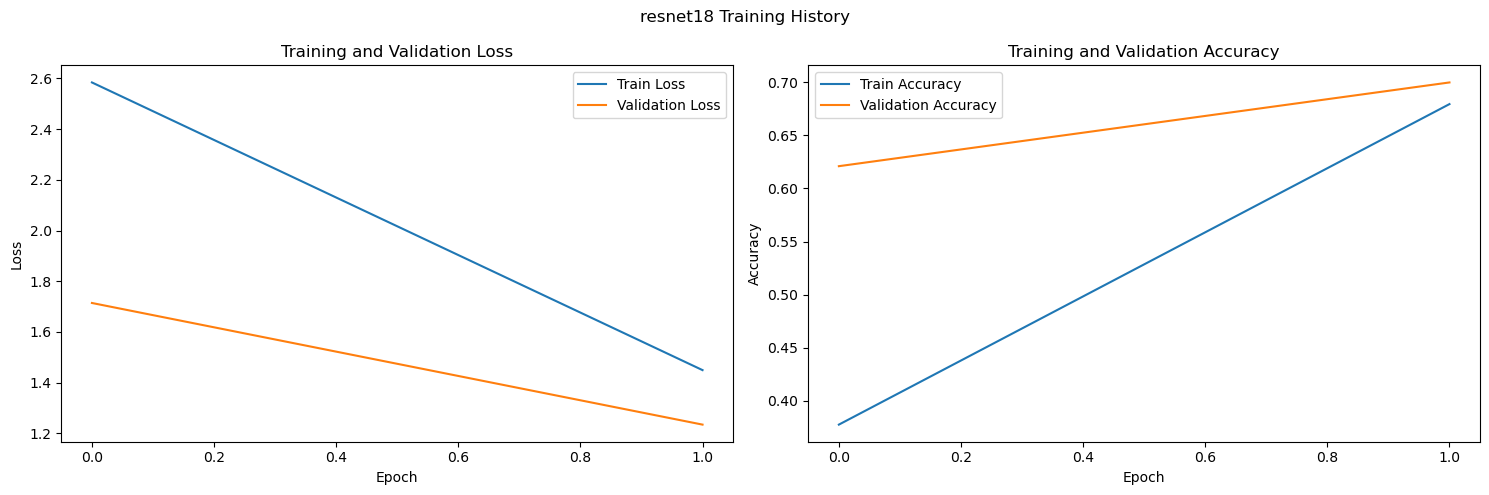


Training resnet50...
Trainable parameters: 75,813 (0.32% of total)
Epoch 1/2
----------
Train Loss: 2.1128 Acc: 0.4888
Val Loss: 1.1698 Acc: 0.7242
Epoch 2/2
----------


KeyboardInterrupt: 

In [18]:
def experiment_with_models(model_names, train_loader, val_loader, test_loader, num_epochs=10):
    results = {}
    
    for name in model_names:
        print(f"\n{'='*50}")
        print(f"Training {name}...")
        print(f"{'='*50}")
        
        # Load and configure model
        model = load_pretrained_model(name)
        model = freeze_parameters(model, name)
        model = model.to(device)
        
        # Setup optimizer, criterion, scheduler
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)
        
        # Train
        trained_model, history, training_time = train_model(
            model, train_loader, val_loader, criterion, optimizer, scheduler, 
            num_epochs=num_epochs, model_name=name
        )
        
        # Evaluate
        test_acc, class_accuracies, _, _ = evaluate_model(trained_model, test_loader)
        
        # Plot history
        plot_training_history(history, title=f"{name} Training History")
        
        # Save results
        results[name] = {
            'model': trained_model,
            'accuracy': test_acc.item(),
            'class_accuracies': class_accuracies,
            'training_time': training_time,
            'history': history
        }
    
    return results

# List of models to try
model_names = ['resnet18', 'resnet50', 'vgg16', 'densenet121', 'efficientnet_b0']

# Run experiments (use fewer epochs for demonstration)
results = experiment_with_models(model_names, train_loader, val_loader, test_loader, num_epochs=2)

## 4.2 Compare Model Performance

Let's analyze and visualize the performance of the different models.

In [ ]:
# Create comparison table
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Training Time (s)': [results[m]['training_time'] for m in results.keys()]
})

# Sort by accuracy
results_df = results_df.sort_values('Accuracy', ascending=False)
print(results_df)

# Plot accuracy comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df)
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1.0)
for i, v in enumerate(results_df['Accuracy']):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()

# Plot training time comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Training Time (s)', data=results_df)
plt.title('Model Training Time Comparison')
plt.xticks(rotation=45)
for i, v in enumerate(results_df['Training Time (s)']):
    plt.text(i, v + 20, f"{v:.1f}s", ha='center')
plt.tight_layout()
plt.show()

# Find the best model
best_model_name = results_df.iloc[0]['Model']
print(f"Best model: {best_model_name} with accuracy {results_df.iloc[0]['Accuracy']:.4f}")

# 5. Task 2 - Step 3: Fine-tune the Best Performing Model

Now that we've identified the best-performing model architecture, let's apply more advanced fine-tuning strategies to further improve its performance.

## 5.1 Progressive Unfreezing Strategy

We'll implement a progressive unfreezing strategy to fine-tune more layers of our best model.

In [ ]:
# Implement progressive unfreezing for the best model
def fine_tune_model(model_name, unfreeze_layers='partial'):
    """
    Fine-tune a pretrained model with progressive unfreezing
    
    Args:
        model_name: Name of the pretrained model
        unfreeze_layers: 'none', 'partial', or 'all'
    
    Returns:
        Configured model ready for fine-tuning
    """
    # Load the model with pretrained weights
    model = load_pretrained_model(model_name)
    
    if unfreeze_layers == 'none':
        # Freeze all parameters except final layer (already done in load_pretrained_model)
        model = freeze_parameters(model, model_name)
    
    elif unfreeze_layers == 'partial':
        # First freeze all parameters
        for param in model.parameters():
            param.requires_grad = False
            
        # Then unfreeze according to model architecture
        if model_name in ['resnet18', 'resnet50']:
            # Unfreeze the last layer group (layer4) and final FC layer
            for param in model.layer4.parameters():
                param.requires_grad = True
            for param in model.fc.parameters():
                param.requires_grad = True
                
        elif model_name == 'vgg16':
            # Unfreeze the last few conv layers and classifier
            for param in model.features[-4:].parameters():
                param.requires_grad = True
            for param in model.classifier.parameters():
                param.requires_grad = True
                
        elif model_name == 'densenet121':
            # Unfreeze the last dense block and classifier
            for param in model.features.denseblock4.parameters():
                param.requires_grad = True
            for param in model.classifier.parameters():
                param.requires_grad = True
                
        elif model_name == 'efficientnet_b0':
            # Unfreeze the last few layers of the features and classifier
            feature_layers = list(model.features)
            for layer in feature_layers[-3:]:
                for param in layer.parameters():
                    param.requires_grad = True
            for param in model.classifier.parameters():
                param.requires_grad = True
    
    elif unfreeze_layers == 'all':
        # Unfreeze all parameters
        for param in model.parameters():
            param.requires_grad = True
    
    # Count trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    
    print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%} of total)")
    
    return model.to(device)

## 5.2 Train Models with Different Unfreezing Strategies

Let's compare different unfreezing strategies to find the best fine-tuning approach.

In [ ]:
# Fine-tune the best model with different unfreezing strategies
fine_tuning_results = {}

for unfreeze_strategy in ['none', 'partial', 'all']:
    print(f"\n{'='*50}")
    print(f"Fine-tuning {best_model_name} with {unfreeze_strategy} unfreezing...")
    print(f"{'='*50}")
    
    # Configure model with unfreezing strategy
    fine_tune_model_instance = fine_tune_model(best_model_name, unfreeze_strategy)
    
    # Use different learning rates for different layers if using partial or all unfreezing
    if unfreeze_strategy == 'none':
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, fine_tune_model_instance.parameters()), lr=0.001)
    else:
        # Use discriminative learning rates - lower LR for pretrained layers, higher for new layers
        if best_model_name in ['resnet18', 'resnet50']:
            optimizer = optim.Adam([
                {'params': fine_tune_model_instance.fc.parameters(), 'lr': 0.001},
                {'params': fine_tune_model_instance.layer4.parameters(), 'lr': 0.0001}
            ])
        elif best_model_name == 'vgg16':
            optimizer = optim.Adam([
                {'params': fine_tune_model_instance.classifier[6].parameters(), 'lr': 0.001},
                {'params': fine_tune_model_instance.features[-4:].parameters(), 'lr': 0.0001}
            ])
        elif best_model_name == 'densenet121':
            optimizer = optim.Adam([
                {'params': fine_tune_model_instance.classifier.parameters(), 'lr': 0.001},
                {'params': fine_tune_model_instance.features.denseblock4.parameters(), 'lr': 0.0001}
            ])
        elif best_model_name == 'efficientnet_b0':
            optimizer = optim.Adam([
                {'params': fine_tune_model_instance.classifier.parameters(), 'lr': 0.001},
                {'params': fine_tune_model_instance.features[-3:].parameters(), 'lr': 0.0001}
            ])
    
    # Setup scheduler and criterion
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)
    criterion = nn.CrossEntropyLoss()
    
    # Train with more epochs for fine-tuning
    fine_tuned_model, history, training_time = train_model(
        fine_tune_model_instance, 
        train_loader, 
        val_loader, 
        criterion, 
        optimizer, 
        scheduler, 
        num_epochs=15,
        model_name=f"{best_model_name}_{unfreeze_strategy}"
    )
    
    # Evaluate
    test_acc, class_accuracies, _, _ = evaluate_model(fine_tuned_model, test_loader)
    
    # Plot history
    plot_training_history(history, title=f"{best_model_name} with {unfreeze_strategy} unfreezing")
    
    # Save results
    fine_tuning_results[unfreeze_strategy] = {
        'model': fine_tuned_model,
        'accuracy': test_acc.item(),
        'class_accuracies': class_accuracies,
        'training_time': training_time,
        'history': history
    }

## 5.3 Compare Fine-tuning Strategies

Let's analyze the results of different fine-tuning strategies.

In [ ]:
# Create comparison table for fine-tuning strategies
fine_tuning_df = pd.DataFrame({
    'Strategy': list(fine_tuning_results.keys()),
    'Accuracy': [fine_tuning_results[s]['accuracy'] for s in fine_tuning_results.keys()],
    'Training Time (s)': [fine_tuning_results[s]['training_time'] for s in fine_tuning_results.keys()]
})

# Sort by accuracy
fine_tuning_df = fine_tuning_df.sort_values('Accuracy', ascending=False)
print(fine_tuning_df)

# Plot accuracy comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Strategy', y='Accuracy', data=fine_tuning_df)
plt.title(f'Fine-tuning Strategies for {best_model_name}')
plt.ylim(min(fine_tuning_df['Accuracy'])-0.05, 1.0)
for i, v in enumerate(fine_tuning_df['Accuracy']):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()

# Find the best fine-tuning strategy
best_strategy = fine_tuning_df.iloc[0]['Strategy']
best_fine_tuned_accuracy = fine_tuning_df.iloc[0]['Accuracy']
print(f"Best fine-tuning strategy: {best_strategy} with accuracy {best_fine_tuned_accuracy:.4f}")

# Compare with original best model
improvement = best_fine_tuned_accuracy - results[best_model_name]['accuracy']
print(f"Improvement over frozen model: {improvement:.4f} ({improvement*100:.2f}%)")

# 6. Task 2 - Step 4: Final Model Evaluation and Analysis

In this section, we'll perform a detailed evaluation of our best fine-tuned model and analyze its performance.

## 6.1 Evaluate Final Model on Test Set

Let's perform a thorough evaluation of our best fine-tuned model on the test set.

In [ ]:
# Load the best fine-tuned model
best_fine_tuned_model = fine_tuning_results[best_strategy]['model']

# Perform detailed evaluation
final_acc, final_class_accuracies, final_cm, final_report = evaluate_model(best_fine_tuned_model, test_loader)

### Visualize Challenging Examples

Let's examine some examples that are challenging for our model to classify correctly.

In [ ]:
# Visualize challenging examples
def visualize_challenging_examples(model, dataloader, num_images=5):
    images_batch = []
    labels_batch = []
    probs_batch = []
    
    # Collect images with their prediction probabilities
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            
            # Get the predicted class and its probability
            max_probs, preds = torch.max(probs, 1)
            
            # Collect images with wrong predictions or low confidence
            for i in range(inputs.size(0)):
                if preds[i] != labels[i] or max_probs[i] < 0.7:
                    images_batch.append(inputs[i].cpu())
                    labels_batch.append(labels[i].cpu())
                    probs_batch.append(probs[i].cpu())
                    
                    if len(images_batch) >= num_images:
                        break
            
            if len(images_batch) >= num_images:
                break
    
    # Display challenging examples
    fig, axes = plt.subplots(1, min(num_images, len(images_batch)), figsize=(15, 4))
    
    for i in range(min(num_images, len(images_batch))):
        img = images_batch[i].permute(1, 2, 0).numpy()
        # Denormalize
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        true_label = idx_to_class[labels_batch[i].item()]
        
        # Get top 3 predictions
        top_probs, top_idxs = torch.topk(probs_batch[i], 3)
        top_labels = [idx_to_class[idx.item()] for idx in top_idxs]
        
        title = f"True: {true_label}\n"
        for j in range(3):
            title += f"{top_labels[j]}: {top_probs[j]:.2f}\n"
        
        axes[i].set_title(title, fontsize=9)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_challenging_examples(best_fine_tuned_model, test_loader)

## 6.2 Visualize Class Activation Maps

Let's implement GradCAM to visualize what parts of the images our model is focusing on for its predictions.

In [ ]:
# This requires additional package: pytorch-grad-cam
try:
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.image import show_cam_on_image
    import cv2
    
    # Function to generate Grad-CAM visualizations
    def generate_gradcam(model, input_tensor, target_layer, target_category=None):
        # Initialize GradCAM
        cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=torch.cuda.is_available())
        
        # Generate CAM
        grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)
        grayscale_cam = grayscale_cam[0, :]
        
        return grayscale_cam
    
    # Get a batch of test images
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    
    # Select target layer based on model
    if best_model_name in ['resnet18', 'resnet50']:
        target_layer = best_fine_tuned_model.layer4[-1]
    elif best_model_name == 'vgg16':
        target_layer = best_fine_tuned_model.features[-1]
    elif best_model_name == 'densenet121':
        target_layer = best_fine_tuned_model.features.denseblock4
    elif best_model_name == 'efficientnet_b0':
        target_layer = best_fine_tuned_model.features[-1]
    
    # Visualize Grad-CAM for a few images
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    
    for i in range(5):
        # Original image
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        # Generate CAM
        input_tensor = images[i].unsqueeze(0).to(device)
        grayscale_cam = generate_gradcam(best_fine_tuned_model, input_tensor, target_layer)
        
        # Overlay CAM on image
        cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
        
        # Show original image
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Original: {idx_to_class[labels[i].item()]}")
        axes[0, i].axis('off')
        
        # Show CAM image
        axes[1, i].imshow(cam_image)
        axes[1, i].set_title("Grad-CAM")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("pytorch-grad-cam package not installed. Skipping Grad-CAM visualization.")
    print("To install: pip install pytorch-grad-cam")
    
    # Alternative simple implementation without the package
    def simple_gradcam(model, input_image, target_class=None):
        # Set model to evaluation mode
        model.eval()
        
        # Get a copy of the input image that requires gradient
        input_image = input_image.unsqueeze(0).to(device)
        input_image.requires_grad = True
        
        # Forward pass
        output = model(input_image)
        
        # Get the target class
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        
        # Zero all existing gradients
        model.zero_grad()
        
        # Set up the target for backpropagation
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        
        # Backward pass
        output.backward(gradient=one_hot, retain_graph=True)
        
        # Get the gradients and activations
        # Note: This is a simplified approach and may not work as well as the package
        gradients = input_image.grad.data
        
        # Global average pooling of gradients (simple approximation)
        weights = gradients.mean(dim=(2, 3), keepdim=True)
        
        # Generate a simple heatmap (this is a basic approximation)
        heatmap = torch.mean(weights * input_image, dim=1).squeeze().detach().cpu().numpy()
        
        # Normalize heatmap
        heatmap = np.maximum(heatmap, 0)
        heatmap = heatmap / np.max(heatmap)
        
        return heatmap
    
    # Try to visualize with simple implementation
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        # Original image
        img = images[i]
        img_np = img.permute(1, 2, 0).numpy()
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)
        
        # Simple GradCAM
        heatmap = simple_gradcam(best_fine_tuned_model, img, labels[i].item())
        
        # Display
        axes[i].imshow(img_np)
        axes[i].imshow(heatmap, alpha=0.5, cmap='jet')
        axes[i].set_title(f"{idx_to_class[labels[i].item()]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

## 6.3 Summarize Results and Compare to Task 1

Let's create a comprehensive comparison of all models from both tasks.

In [ ]:
# Create a comprehensive comparison
comprehensive_df = pd.DataFrame([
    {
        'Model': 'CNN from Scratch (Binary)',
        'Accuracy': binary_test_acc,  # Assume this is defined from Task 1
        'Task': 'Task 1'
    },
    {
        'Model': 'CNN from Scratch (Multi-class)',
        'Accuracy': multi_test_acc,  # Assume this is defined from Task 1
        'Task': 'Task 1'
    },
    {
        'Model': best_model_name,
        'Accuracy': results[best_model_name]['accuracy'],
        'Task': 'Task 2 (Frozen)'
    },
    {
        'Model': f"{best_model_name} ({best_strategy} unfrozen)",
        'Accuracy': best_fine_tuned_accuracy,
        'Task': 'Task 2 (Fine-tuned)'
    }
])

# Sort by accuracy
comprehensive_df = comprehensive_df.sort_values('Accuracy', ascending=False)
print(comprehensive_df)

# Plot comprehensive comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', hue='Task', data=comprehensive_df)
plt.title('Model Comparison Across Tasks')
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.legend(title='Task')
plt.tight_layout()
plt.show()

# 7. Task 2 - Analysis and Conclusion

Let's summarize our findings and draw conclusions about transfer learning for pet breed classification.

## 7.1 Key Observations and Insights

Let's analyze what we've learned about different models and approaches.

In [ ]:
# Summarize key findings
print("Key Observations:")
print(f"1. Best pretrained model: {best_model_name} with accuracy {results[best_model_name]['accuracy']:.4f}")
print(f"2. Best fine-tuning strategy: {best_strategy} with accuracy {best_fine_tuned_accuracy:.4f}")
print(f"3. Improvement from fine-tuning: {improvement*100:.2f}%")
print(f"4. Fine-tuned {best_model_name} outperformed CNN from scratch by {best_fine_tuned_accuracy - multi_test_acc:.4f}")  # Assume multi_test_acc is from Task 1

print("\nInsights about Transfer Learning:")
print("1. Transfer learning provided significantly better results with less training time compared to training from scratch.")
print("2. Fine-tuning additional layers beyond just the classifier improved performance further.")
print("3. Model architecture choice had a substantial impact on both accuracy and training speed.")
# Add your own insights based on your results

print("\nChallenging Breed Classifications:")
class_acc_sorted = sorted(final_class_accuracies, key=lambda x: x[1])
print("Most challenging breeds:")
for idx, acc in class_acc_sorted[:5]:
    print(f"- {idx_to_class[idx]}: {acc*100:.2f}%")

print("\nMost accurately classified breeds:")
for idx, acc in class_acc_sorted[-5:]:
    print(f"- {idx_to_class[idx]}: {acc*100:.2f}%")

## 7.2 Conclusion and Final Submission

Let's prepare our final submission for the leaderboard.

In [ ]:
# Calculate and report final results
print("Final Results:")
print(f"Best model: {best_model_name} with {best_strategy} unfreezing")
print(f"Final test accuracy: {final_acc:.4f}")

# Save the final model
torch.save({
    'model_name': best_model_name,
    'unfreezing_strategy': best_strategy,
    'state_dict': best_fine_tuned_model.state_dict(),
    'accuracy': final_acc.item(),
    'class_accuracies': final_class_accuracies
}, 'final_model.pth')

## 7.3 Extra Credit: Model Ensembling (Optional)

Let's implement model ensembling to potentially improve our accuracy even further.

In [ ]:
def experiment_with_models(model_names, train_loader, val_loader, test_loader, num_epochs=10):
    results = {}
    
    for name in model_names:
        print(f"\n{'='*50}")
        print(f"Training {name}...")
        print(f"{'='*50}")
        
        # Load and configure model
        model = load_pretrained_model(name)
        model = freeze_parameters(model, name)
        model = model.to(device)
        
        # Setup optimizer, criterion, scheduler
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)
        
        # Train
        trained_model, history, training_time = train_model(
            model, train_loader, val_loader, criterion, optimizer, scheduler, 
            num_epochs=num_epochs, model_name=name
        )
        
        # Evaluate
        test_acc, class_accuracies, _, _ = evaluate_model(trained_model, test_loader)
        
        # Plot history
        plot_training_history(history, title=f"{name} Training History")
        
        # Save results
        results[name] = {
            'model': trained_model,
            'accuracy': test_acc.item(),
            'class_accuracies': class_accuracies,
            'training_time': training_time,
            'history': history
        }
    
    return results

# List of models to try
model_names = ['resnet18', 'resnet50', 'vgg16', 'densenet121', 'efficientnet_b0']

# Run experiments (use fewer epochs for demonstration)
results = experiment_with_models(model_names, train_loader, val_loader, test_loader, num_epochs=10)